<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
## openEO Platform DEMO
Sentinel 2 data over an alpine region

In [1]:
import openeo

In [2]:
openeo.client_version()

'0.10.0'

## Connect to openEO

Via egi-checkin using the aggregator

In [3]:
#eodc_backend = "https://openeo.eodc.eu/v1.0"
openeo_aggregator = "openeo.cloud"
conn = openeo.connect(openeo_aggregator)

In [4]:
conn = conn.authenticate_oidc(provider_id="egi")

Authenticated using refresh token.


In [5]:
conn.describe_account()

{'user_id': 'us-b323a1d5-0793-4286-bde9-f5c24c7ac4ac'}

List and describe available collections

In [6]:
conn.list_collections()

[{'description': 'Sentinel-2 is a multispectral, high-resolution, optical imaging mission, developed by the European Space Agency (ESA) in the frame of the Copernicus program of the European Commission. This is a full archive of Sentinel-2a and Sentinel-2b L1C imagery. The 13 bands and their radiometric resolution are listed here: [Radiometric Resolutions](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/radiometric). Please also consider [Sentinel-2 User Handbook](https://sentinel.esa.int/documents/247904/685211/Sentinel-2_User_Handbook) for information about the Sentinel-2 mission. Level 1 data is not directly available in the open-datacube. If you want to use any processes please run  ``load_collection()`` / ``save_result()`` in a first job. Then create a second job and using the previous job results with the ``load_results()`` process as input. The second job may then use all but the ARD processes available in the back-end. It is recommended to use the process ``atmospheric_correction()`` before further analysis of the data.',
  'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]},
   'temporal': {'interval': [[None, None]]}},
  'id': 'SENTINEL2_L1C',
  'keywords': ['Sentinel-2',
   'Sentinel-2 full archive',
   'Level-1C',
   'Copernicus',
   'EODC',
   'ESA',
   'MSI'],
  'license': 'no conditions apply',
  'links': [{'href': 'https://openeo.eodc.eu/v1.0/collections/SENTINEL2_L1C',
    'rel': 'self'},
   {'href': 'https://openeo.eodc.eu/v1.0/collections', 'rel': 'parent'},
   {'href': 'https://openeo.eodc.eu/v1.0/collections', 'rel': 'root'}],
  'stac_extensions': ['datacube', 'eo'],
  'stac_version': '0.9.0',
  'title': 'Sentinel-2 Level-1C'},
 {'description': 'Sentinel-1 is an imaging radar mission providing continuous all-weather, day-and-night imagery at C-band. This is a full IW acquisition archive of both Sentinel-1a and Sentinel-1b imagery. The Sentinel-1 constellation provides high reliability, improved revisit time, geographical coverage and rapid data dissemination to support operational applications in the priority areas of marine monitoring, land monitoring and emergency services. Currently Level-1 collections can only be used with ARD processes (``ard_normalized_radar_backscatter()``, ``sar_backscatter()``) and ``load_collection()`` / ``save_result()``. If you want to use other processes, first perform ARD processing and save your results. Then create a second job using the previous job results with the ``load_results()`` process as input. The second job may then use all but the ARD processes available in the back-end.',
  'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]},
   'temporal': {'interval': [[None, None]]}},
  'id': 'SENTINEL1_GRD',
  'keywords': ['Sentinel-1',
   'Sentinel-1 IW full archive',
   'Level-1',
   'IW',
   'GRDH',
   'GRD',
   'Remote Sensing',
   'Radar',
   'EODC',
   'Satellite',
   'imageryBaseMapsEarthCover'],
  'license': 'no conditions apply',
  'links': [{'href': 'https://openeo.eodc.eu/v1.0/collections/SENTINEL1_GRD',
    'rel': 'self'},
   {'href': 'https://openeo.eodc.eu/v1.0/collections', 'rel': 'parent'},
   {'href': 'https://openeo.eodc.eu/v1.0/collections', 'rel': 'root'}],
  'stac_extensions': ['datacube', 'sar'],
  'stac_version': '0.9.0',
  'title': 'Sentinel-1 GRDH IW LEVEL-1C'},
 {'description': 'Preprocessed analysis-read-data (ARD) from Landsat-8 processed with FORCE. ARD data can only be combined with other ARD data or loaded results of previous processed jobs. ARD data cannot be combined with Level-1 collections! As this is Level-2 (ARD) data, ARD processes (``ard_normalized_radar_backscatter()``, ``ard_surface_reflectance()``, ``sar_backscatter()``, ``atmospheric_correction()``) cannot be applied.',
  'extent': {'spatial': {'bbox': [[5.014148226142465,
      42.50120437013096,
      18.59706624229073,
      51.419674834228985]]},
   'temporal': {'interval': [['2015-01-04T12:00:00+00:00',
      '2020-12-26T12:00

#### Using the boa_sentinel_2 collection to get an alpine region NDVI

In [7]:
from eo_utils import *
center = [47, 12.84]
zoom = 12

eoMap = openeoMap(center,zoom)
eoMap.map

Map(center=[47, 12.84], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [8]:
bbox = eoMap.getBbox()
print('west',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

west 12.695217 
east 12.984123 
south 46.957879 
north 47.045797


Looking at changes over one year

In [9]:
collection      = 'boa_sentinel_2'

spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2019-01-01", "2019-12-31"] 

bands           = ["B02", "B03", "B04", "B08"] 

data = conn.load_collection(collection, spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

In [10]:
data_agg = data.aggregate_temporal_period(reducer="mean", period="month", dimension="t")
data_agg_clipped = data_agg.apply(lambda x: x.clip(min=0, max=6000))
data_agg_ndvi = data_agg_clipped.apply(lambda x: x.ndvi(nir="B08", red="B04"))

In [11]:
data_agg_ndvi_saved = data_agg_ndvi.save_result(format="NetCDF")

In [12]:
job = data_agg_ndvi_saved.create_job(title = "BOA_S2_alpine_region")

jobID = job.job_id
jobId = conn.job(jobID)

In [13]:
job.start_job()

In [16]:
job

<RESTJob job_id='jb-ffd5eea9-b935-4134-9703-309b50e99d25'>

In [18]:
results = jobId.get_results()
metadata = results.get_metadata()
results.download_files("./demo_data/")

[PosixPath('demo_data/out_2022_05_11T16_40_30_EU010M_E049N015T1.nc'),
 PosixPath('demo_data/out_2022_05_11T16_40_30_EU010M_E050N015T1.nc')]

In [20]:
output_data5 = xr.open_dataset("./demo_data/out_2022_05_11T16_40_30_EU010M_E049N015T1.nc")
output_data5 = output_data5.where(output_data5!=-9999, np.nan)

In [21]:
output_data5

<xarray.Dataset>
Dimensions:      (month: 12, y: 1303, x: 2149)
Coordinates:
  * y            (y) float64 1.525e+06 1.525e+06 ... 1.512e+06 1.512e+06
  * x            (x) float64 4.979e+06 4.979e+06 4.979e+06 ... 5e+06 5e+06 5e+06
    spatial_ref  int32 0
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    t            datetime64[ns] 2022-05-11T16:40:30.617749
Data variables:
    result       (month, y, x) float64 nan nan nan ... 0.07442 0.02316 0.01183
Attributes:
    crs:                PROJCRS["Azimuthal_Equidistant",BASEGEOGCRS["WGS 84",...
    datetime_from_dim:  2022-05-11 16:40:30.623520

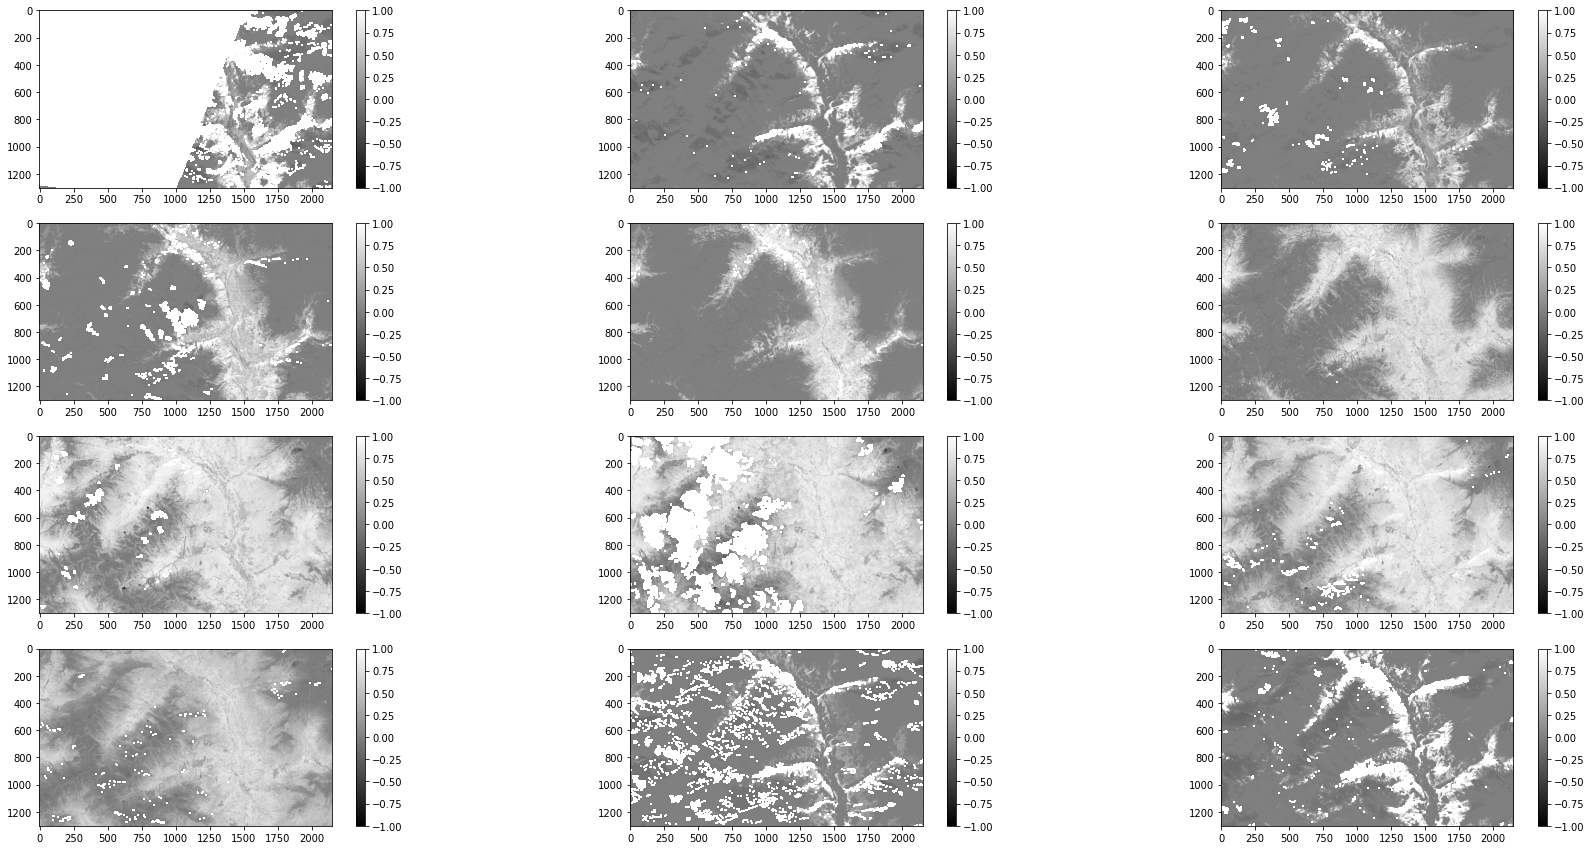

In [26]:
plt.figure(figsize=(30,15))

for i in range(1,13):
    month = output_data5.result.sel(month=i)
    plt.subplot(4,3,i)
    plt.imshow(month, cmap = "gray", vmin=-1, vmax=1)   
    plt.colorbar()